<a href="https://colab.research.google.com/github/nima34366/ECG_Classification/blob/main/ECG_Multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
import uuid
import os
import tensorflow as tf
!pip install visualkeras
import visualkeras
from tensorflow.keras.layers import Dense, MaxPooling1D, Conv1D, SpatialDropout1D, Flatten, GlobalAveragePooling1D, Dropout, AveragePooling1D, Input, Concatenate, Activation, Add, BatchNormalization
from tensorflow.keras.models import Model
from IPython.display import Image
import tensorflow.keras.backend as K
import sklearn.metrics
import numpy as np
import itertools
!pip install tensorflow-addons
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import io
from IPython.display import clear_output
!wget https://raw.githubusercontent.com/physionetchallenges/evaluation-2021/main/weights.csv
!pip install shap
import shap
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm
import pickle
!pip install neurokit2
import neurokit2 as nk
import string
!pip install wandb
import wandb
from wandb.keras import WandbCallback

In [ ]:
# Code used to preprocess the data. 
# Preprocessed data are already saved in Google buckets.
# They are accessed by the TPU when running the code.

# twelve_leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')
# six_leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF')
# four_leads = ('I', 'II', 'III', 'V2')
# three_leads = ('I', 'II', 'V2')
# two_leads = ('I', 'II')
# lead_sets = (twelve_leads, six_leads, four_leads, three_leads, two_leads)

# def _bytes_feature(value):
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
    
# def generate_image(recording,label):
#     fftsignals = fft(recording)
#     mag = np.absolute(fftsignals)
#     mag = np.clip(mag,0,500)
#     mag = mag[:,:2000]
#     angle = np.angle(fftsignals)
#     angle = angle[:,:2000]
#     recording = resample(recording,2000,axis=1)
#     image = np.vstack((recording,mag,angle))
#     image = np.transpose(image,(1,0)).astype(np.float32)
#     label = label.astype(np.float32)
#     image_byte=image.tobytes()
#     label_byte=label.tobytes()
#     dataset = {'image': _bytes_feature(image_byte), 'label': _bytes_feature(label_byte)}
#     feature = tf.train.Features(feature=dataset)
#     example = tf.train.Example(features=feature)
#     serialized = example.SerializeToString()
#     writer_train.write(serialized)
# labels=["164889003","164890007","6374002","426627000","733534002","713427006","270492004","713426002","39732003","445118002","251146004","698252002","426783006","284470004","10370003","365413008","427172004","164947007","111975006","164917005","47665007","427393009","426177001","427084000","164934002","59931005"]
# header_files,recording_files=find_challenge_files(data_directory)

# num_trainingdata_in_batch= len(header_files)//10
# for j in range(10):
#     print('Preprocessing....'+str(j+1)+' out of 10')
#     with tf.io.TFRecordWriter('processed_train'+str(j)+'.tfrecord') as writer_train:
#         for i in range(j*num_trainingdata_in_batch,(j+1)*num_trainingdata_in_batch):
#             header=load_header(header_files[i])
#             recording=load_recording(recording_files[i])
#             frequency=int(get_frequency(header))
#             num_samples=int(get_num_samples(header))
#             if num_samples>(20*frequency):
#                 continue
#             current_labels=get_labels(header)
#             current_labels=["733534002" if j == "164909002" else "713427006" if j == "59118001" else "284470004" if j == "63593006" else "427172004" if j == "17338001" else j for j in current_labels]
#             label=np.zeros(26,dtype=np.uint8)
#             label_indices = [k for k in range(len(labels)) if labels[k] in current_labels]
#             label[label_indices]=1
#             recording=np.array(choose_leads(recording, header, twelve_leads),dtype=np.float32)
#             adc_gains = get_adc_gains(header, twelve_leads).reshape(12, 1)
#             baselines = get_baselines(header, twelve_leads).reshape(12, 1)
#             recording = (recording - baselines)/adc_gains
#             recording = np.hstack((recording,np.zeros((12,20*frequency-num_samples))))
#             recording = resample(recording,4000,axis=1)
#             generate_image(recording, label)
# print('Preprocessing Done')

In [ ]:
# Authentication necessary to access google buckets and WandB
# Google buckets are now publicly accessible

# auth.authenticate_user()
# !gcloud config set project projectecg-331808
# wandb.login()
# clear_output()

In [2]:
# Connect to TPU

print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
clear_output()

# Normal Model Training

In [3]:
noleads = 2

def create_model():
    i = Input((2000,noleads), name='signal')
    x = Conv1D(filters=72, kernel_size=15, activation='swish', padding='same')(i)
    a = Conv1D(filters=72, kernel_size=1, padding='same')(i)
    a = Add()([a,x])
    a = Activation('swish')(a)
    x = SpatialDropout1D(0.2)(a)
    b = AveragePooling1D(pool_size=2)(x)
    x = Conv1D(filters=144, kernel_size=3, activation='swish', padding='same')(b)
    a = Conv1D(filters=144, kernel_size=1, padding='same')(b)
    a = Add()([a,x])
    a = Activation('swish')(a)
    x = SpatialDropout1D(0.2)(a)
    b = AveragePooling1D(pool_size=2)(x)
    x = Conv1D(filters=288, kernel_size=5, activation='swish', padding='same')(b)
    a = Conv1D(filters=288, kernel_size=1, padding='same')(b)
    a = Add()([a,x])
    a = Activation('swish')(a)
    x = SpatialDropout1D(0.2)(a)
    b = AveragePooling1D(pool_size=2)(x)
    x = Conv1D(filters=576, kernel_size=7, activation='swish', padding='same')(b)
    a = Conv1D(filters=576, kernel_size=1, padding='same')(b)
    a = Add()([a,x])
    a = Activation('swish')(a)
    b = SpatialDropout1D(0.2)(a)
    x = GlobalAveragePooling1D()(b)

    j = Input((2000,2*noleads), name='fft')
    y = Conv1D(filters=72, kernel_size=3, activation='swish', padding='same')(j)
    y = SpatialDropout1D(0.1)(y)
    y = AveragePooling1D(pool_size=2)(y)
    y = Conv1D(filters=144, kernel_size=5, activation='swish', padding='same')(y)
    y = SpatialDropout1D(0.1)(y)
    y = AveragePooling1D(pool_size=2)(y)
    y = Conv1D(filters=288, kernel_size=7, activation='swish', padding='same')(y)
    y = SpatialDropout1D(0.1)(y)
    y = AveragePooling1D(pool_size=2)(y)
    y = Conv1D(filters=576, kernel_size=9, activation='swish', padding='same')(y)
    y = SpatialDropout1D(0.1)(y)
    y = AveragePooling1D(pool_size=2)(y)
    y = Conv1D(filters=1152, kernel_size=11, activation='swish', padding='same')(y)
    y = SpatialDropout1D(0.1)(y)
    y = GlobalAveragePooling1D()(y)

    f = Concatenate()([x,y])
    f = Activation('swish')(f)

    f = Dense(576, activation='swish')(f)
    f = Dropout(0.5)(f)
    f = Dense(26,activation = 'sigmoid')(f)
    AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC',multi_label = True)
    AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC',multi_label = True)
    model = Model([i,j],f)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', AUROC, AUPRC])
    # tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,layer_range=None, show_layer_activations=False)
    return model

with tpu_strategy.scope():
    model = create_model()



In [4]:
def indices(leads):
    if leads==12:
        pos1 = [0,1,2,3,4,5,6,7,8,9,10,11]
        pos2 = [12,24,13,25,14,26,15,27,16,28,17,29,18,30,19,31,20,32,21,33,22,34,23,35]
    elif leads==6:
        pos1 = [0,1,2,3,4,5]
        pos2 = [12,24,13,25,14,26,15,27,16,28,17,29]
    elif leads==4:
        pos1 = [0,1,2,7]
        pos2 = [12,24,13,25,14,26,19,31]
    elif leads==3:
        pos1 = [0,1,7]
        pos2 = [12,24,13,25,19,31]
    else:
        pos1 = [0,1]
        pos2 = [12,24,13,25]
    return pos1,pos2

def parse_example(serialized, image_shape=(2000, 36),label_shape=(26,)):
    features = {'image': tf.io.FixedLenFeature([], tf.string), 'label': tf.io.FixedLenFeature([], tf.string)}
    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)
    label_raw = parsed_example['label']
    image_raw = parsed_example['image']
    image = tf.io.decode_raw(image_raw, tf.float32)
    image = tf.reshape(image, shape=image_shape)
    signal = tf.experimental.numpy.take(image,indices(noleads)[0],axis=-1)
    image = tf.experimental.numpy.take(image,indices(noleads)[1],axis=-1)
    label = tf.io.decode_raw(label_raw, tf.float32)
    label = tf.reshape(label, shape=label_shape)
    return {'signal':signal,'fft':image}, label

AUTOTUNE=tf.data.AUTOTUNE
train_files = tf.io.matching_files('gs://nima_ecg/early/processed_train*.tfrecord')
train_files = tf.random.shuffle(train_files)
shards = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(parse_example, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.prefetch(AUTOTUNE)

test_dataset = tf.data.TFRecordDataset('gs://nima_ecg/early/processed_test.tfrecord')
test_dataset = test_dataset.map(parse_example,num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(128, drop_remainder=True)
test_dataset = test_dataset.prefetch(AUTOTUNE)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_AUPRC',patience=5, min_delta=0.01, mode='max')

In [5]:
model.fit(train_dataset,validation_data=test_dataset,epochs=40,callbacks=[callback])

Epoch 1/40
605/605 [==============================] - 141s 142ms/step - loss: 0.1550 - accuracy: 0.4289 - AUROC: 0.7311 - AUPRC: 0.1775 - val_loss: 0.1307 - val_accuracy: 0.5384 - val_AUROC: 0.8105 - val_AUPRC: 0.2588
Epoch 2/40
605/605 [==============================] - 29s 46ms/step - loss: 0.1229 - accuracy: 0.5495 - AUROC: 0.8232 - AUPRC: 0.2818 - val_loss: 0.1189 - val_accuracy: 0.5613 - val_AUROC: 0.8409 - val_AUPRC: 0.3093
Epoch 3/40
605/605 [==============================] - 29s 46ms/step - loss: 0.1137 - accuracy: 0.5711 - AUROC: 0.8541 - AUPRC: 0.3267 - val_loss: 0.1138 - val_accuracy: 0.5678 - val_AUROC: 0.8631 - val_AUPRC: 0.3437
Epoch 4/40
605/605 [==============================] - 29s 47ms/step - loss: 0.1073 - accuracy: 0.5877 - AUROC: 0.8743 - AUPRC: 0.3602 - val_loss: 0.1521 - val_accuracy: 0.4867 - val_AUROC: 0.8199 - val_AUPRC: 0.2848
Epoch 5/40
605/605 [==============================] - 29s 47ms/step - loss: 0.1127 - accuracy: 0.5743 - AUROC: 0.8622 - AUPRC: 0.3387 

In [ ]:
K.set_value(model.optimizer.learning_rate, 0.0001)

In [ ]:
model.fit(train_dataset,validation_data=test_dataset,epochs=10, callbacks=[callback])

Epoch 1/10
605/605 [==============================] - 36s 59ms/step - loss: 0.0503 - accuracy: 0.6904 - AUROC: 0.9766 - AUPRC: 0.7288 - val_loss: 0.0630 - val_accuracy: 0.6607 - val_AUROC: 0.9555 - val_AUPRC: 0.6607
Epoch 2/10
605/605 [==============================] - 36s 58ms/step - loss: 0.0479 - accuracy: 0.6919 - AUROC: 0.9786 - AUPRC: 0.7450 - val_loss: 0.0631 - val_accuracy: 0.6607 - val_AUROC: 0.9550 - val_AUPRC: 0.6617
Epoch 3/10
605/605 [==============================] - 35s 57ms/step - loss: 0.0469 - accuracy: 0.6941 - AUROC: 0.9800 - AUPRC: 0.7524 - val_loss: 0.0631 - val_accuracy: 0.6573 - val_AUROC: 0.9552 - val_AUPRC: 0.6635
Epoch 4/10
605/605 [==============================] - 35s 57ms/step - loss: 0.0464 - accuracy: 0.6960 - AUROC: 0.9806 - AUPRC: 0.7563 - val_loss: 0.0633 - val_accuracy: 0.6611 - val_AUROC: 0.9547 - val_AUPRC: 0.6634
Epoch 5/10
605/605 [==============================] - 35s 57ms/step - loss: 0.0457 - accuracy: 0.6969 - AUROC: 0.9810 - AUPRC: 0.7607 - 

# WandB
Used WandB to find the best model hyperparameters. No need to run these now.

In [ ]:
#@title Run
wandb.init(project="ECG", entity="nimawickramasinghe",
           config = {
                'batch_size': 128,
                'activation': 'swish',
                'optimizer': 'adam',
                'base_filter_size': 72,
                'base_kernel_size': 3,
                'dropout': 0.5,
                'spatdropout': 0.1,
            })
config = wandb.config

def create_model():
    i = Input((2000,2), name='signal')
    x = Conv1D(filters=72, kernel_size=15, activation='swish', padding='same')(i)
    a = Conv1D(filters=72, kernel_size=1, padding='same')(i)
    a = Add()([a,x])
    a = Activation('swish')(a)
    x = SpatialDropout1D(0.2)(a)
    b = AveragePooling1D(pool_size=2)(x)
    x = Conv1D(filters=144, kernel_size=3, activation='swish', padding='same')(b)
    a = Conv1D(filters=144, kernel_size=1, padding='same')(b)
    a = Add()([a,x])
    a = Activation('swish')(a)
    x = SpatialDropout1D(0.2)(a)
    b = AveragePooling1D(pool_size=2)(x)
    x = Conv1D(filters=288, kernel_size=5, activation='swish', padding='same')(b)
    a = Conv1D(filters=288, kernel_size=1, padding='same')(b)
    a = Add()([a,x])
    a = Activation('swish')(a)
    x = SpatialDropout1D(0.2)(a)
    b = AveragePooling1D(pool_size=2)(x)
    x = Conv1D(filters=576, kernel_size=7, activation='swish', padding='same')(b)
    a = Conv1D(filters=576, kernel_size=1, padding='same')(b)
    a = Add()([a,x])
    a = Activation('swish')(a)
    b = SpatialDropout1D(0.2)(a)
    x = GlobalAveragePooling1D()(b)

    j = Input((2000,2*2), name='fft')
    y = Conv1D(filters=72, kernel_size=3, activation='swish', padding='same')(j)
    y = SpatialDropout1D(0.1)(y)
    y = AveragePooling1D(pool_size=2)(y)
    y = Conv1D(filters=144, kernel_size=5, activation='swish', padding='same')(y)
    y = SpatialDropout1D(0.1)(y)
    y = AveragePooling1D(pool_size=2)(y)
    y = Conv1D(filters=288, kernel_size=7, activation='swish', padding='same')(y)
    y = SpatialDropout1D(0.1)(y)
    y = AveragePooling1D(pool_size=2)(y)
    y = Conv1D(filters=576, kernel_size=9, activation='swish', padding='same')(y)
    y = SpatialDropout1D(0.1)(y)
    y = AveragePooling1D(pool_size=2)(y)
    y = Conv1D(filters=1152, kernel_size=11, activation='swish', padding='same')(y)
    y = SpatialDropout1D(0.1)(y)
    y = GlobalAveragePooling1D()(y)

    f = Concatenate()([x,y])
    f = Activation('swish')(f)

    f = Dense(576, activation='swish')(f)
    f = Dropout(0.5)(f)
    f = Dense(26,activation = 'sigmoid')(f)
    AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC',multi_label = True)
    AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC',multi_label = True)
    model = Model([i,j],f)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', AUROC, AUPRC])
    # tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,layer_range=None, show_layer_activations=False)
    return model

with tpu_strategy.scope():
    model = create_model()

def indices(leads):
    if leads==12:
        pos1 = [0,1,2,3,4,5,6,7,8,9,10,11]
        pos2 = [12,24,13,25,14,26,15,27,16,28,17,29,18,30,19,31,20,32,21,33,22,34,23,35]
    elif leads==6:
        pos1 = [0,1,2,3,4,5]
        pos2 = [12,24,13,25,14,26,15,27,16,28,17,29]
    elif leads==4:
        pos1 = [0,1,2,7]
        pos2 = [12,24,13,25,14,26,19,31]
    elif leads==3:
        pos1 = [0,1,7]
        pos2 = [12,24,13,25,19,31]
    else:
        pos1 = [0,1]
        pos2 = [12,24,13,25]
    return pos1,pos2

def parse_example(serialized, image_shape=(2000, 36),label_shape=(26,)):
    features = {'image': tf.io.FixedLenFeature([], tf.string), 'label': tf.io.FixedLenFeature([], tf.string)}
    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)
    label_raw = parsed_example['label']
    image_raw = parsed_example['image']
    image = tf.io.decode_raw(image_raw, tf.float32)
    image = tf.reshape(image, shape=image_shape)
    signal = tf.experimental.numpy.take(image,indices(2)[0],axis=-1)
    image = tf.experimental.numpy.take(image,indices(2)[1],axis=-1)
    label = tf.io.decode_raw(label_raw, tf.float32)
    label = tf.reshape(label, shape=label_shape)
    return {'signal':signal,'fft':image}, label

AUTOTUNE=tf.data.AUTOTUNE
train_files = tf.io.matching_files('gs://nima_ecg/early/processed_train*.tfrecord')
train_files = tf.random.shuffle(train_files)
shards = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(parse_example, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.prefetch(AUTOTUNE)

test_dataset = tf.data.TFRecordDataset('gs://nima_ecg/early/processed_test.tfrecord')
test_dataset = test_dataset.map(parse_example,num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(128, drop_remainder=True)
test_dataset = test_dataset.prefetch(AUTOTUNE)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_AUPRC',patience=5, min_delta=0.01, mode='max')

model.fit(train_dataset,validation_data=test_dataset,epochs=40,callbacks=[callback, WandbCallback()])
K.set_value(model.optimizer.learning_rate, 0.0001)
model.fit(train_dataset,validation_data=test_dataset,epochs=10, callbacks=[callback, WandbCallback()])

Epoch 1/40
605/605 [==============================] - 93s 112ms/step - loss: 0.1502 - accuracy: 0.4641 - AUROC: 0.7407 - AUPRC: 0.1868 - val_loss: 0.1288 - val_accuracy: 0.5399 - val_AUROC: 0.8137 - val_AUPRC: 0.2688 - _timestamp: 1649847436.0000 - _runtime: 107.0000
Epoch 2/40
605/605 [==============================] - 30s 48ms/step - loss: 0.1179 - accuracy: 0.5567 - AUROC: 0.8381 - AUPRC: 0.3099 - val_loss: 0.1095 - val_accuracy: 0.5817 - val_AUROC: 0.8767 - val_AUPRC: 0.3728 - _timestamp: 1649847467.0000 - _runtime: 138.0000
Epoch 3/40
605/605 [==============================] - 30s 49ms/step - loss: 0.1052 - accuracy: 0.5874 - AUROC: 0.8795 - AUPRC: 0.3794 - val_loss: 0.0985 - val_accuracy: 0.5967 - val_AUROC: 0.9043 - val_AUPRC: 0.4361 - _timestamp: 1649847497.0000 - _runtime: 168.0000
Epoch 4/40
605/605 [==============================] - 30s 48ms/step - loss: 0.0933 - accuracy: 0.6129 - AUROC: 0.9079 - AUPRC: 0.4411 - val_loss: 0.0924 - val_accuracy: 0.6213 - val_AUROC: 0.9195 - 

In [ ]:
#@title Sweep
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_AUPRC',
      'goal': 'maximize'   
    },
    'parameters': {
        'batch_size': {
            'values': [256, 128, 64, 32]
        },
        'dropout': {
            'values': [0.3, 0.5, 0.7]
        },
        'spatdropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'base_filter_size': {
            'values': [16, 36, 72, 144]
        },
        'base_kernel_size': {
            'values': [3,5]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop']
        },
        'activation': {
            'values': ['relu', 'elu', 'selu', 'softmax', 'swish']
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="nimawickramasinghe", project="ECG")

def train():

    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)

    with tpu_strategy.scope():
        config_defaults = {
            'batch_size': 128,
            'activation': 'relu',
            'optimizer': 'nadam',
            'base_filter_size': 72,
            'base_kernel_size': 3,
            'dropout': 0.1,
            'spatdropout': 0.1,
        }

        wandb.init(config=config_defaults)
        config = wandb.config

        def create_model():
            i = Input((2000,2), name='signal')
            x = Conv1D(filters=config.base_filter_size, kernel_size=15, activation=config.activation, padding='same')(i)
            a = Conv1D(filters=config.base_filter_size, kernel_size=1, padding='same')(i)
            a = Add()([a,x])
            a = Activation(config.activation)(a)
            x = SpatialDropout1D(config.spatdropout*2)(a)
            b = AveragePooling1D(pool_size=2)(x)
            x = Conv1D(filters=config.base_filter_size*2, kernel_size=config.base_kernel_size, activation=config.activation, padding='same')(b)
            a = Conv1D(filters=config.base_filter_size*2, kernel_size=1, padding='same')(b)
            a = Add()([a,x])
            a = Activation(config.activation)(a)
            x = SpatialDropout1D(config.spatdropout*2)(a)
            b = AveragePooling1D(pool_size=2)(x)
            x = Conv1D(filters=config.base_filter_size*4, kernel_size=config.base_kernel_size+2, activation=config.activation, padding='same')(b)
            a = Conv1D(filters=config.base_filter_size*4, kernel_size=1, padding='same')(b)
            a = Add()([a,x])
            a = Activation(config.activation)(a)
            x = SpatialDropout1D(config.spatdropout*2)(a)
            b = AveragePooling1D(pool_size=2)(x)
            x = Conv1D(filters=config.base_filter_size*8, kernel_size=config.base_kernel_size+4, activation=config.activation, padding='same')(b)
            a = Conv1D(filters=config.base_filter_size*8, kernel_size=1, padding='same')(b)
            a = Add()([a,x])
            a = Activation(config.activation)(a)
            b = SpatialDropout1D(config.spatdropout*2)(a)
            x = GlobalAveragePooling1D()(b)

            j = Input((2000,2*2), name='fft')
            y = Conv1D(filters=config.base_filter_size, kernel_size=config.base_kernel_size, activation=config.activation, padding='same')(j)
            y = SpatialDropout1D(config.spatdropout)(y)
            y = AveragePooling1D(pool_size=2)(y)
            y = Conv1D(filters=config.base_filter_size*2, kernel_size=config.base_kernel_size+2, activation=config.activation, padding='same')(y)
            y = SpatialDropout1D(config.spatdropout)(y)
            y = AveragePooling1D(pool_size=2)(y)
            y = Conv1D(filters=config.base_filter_size*4, kernel_size=config.base_kernel_size+4, activation=config.activation, padding='same')(y)
            y = SpatialDropout1D(config.spatdropout)(y)
            y = AveragePooling1D(pool_size=2)(y)
            y = Conv1D(filters=config.base_filter_size*8, kernel_size=config.base_kernel_size+6, activation=config.activation, padding='same')(y)
            y = SpatialDropout1D(config.spatdropout)(y)
            y = AveragePooling1D(pool_size=2)(y)
            y = Conv1D(filters=config.base_filter_size*16, kernel_size=config.base_kernel_size+8, activation=config.activation, padding='same')(y)
            y = SpatialDropout1D(config.spatdropout)(y)
            y = GlobalAveragePooling1D()(y)

            f = Concatenate()([x,y])
            f = Activation(config.activation)(f)

            f = Dense(576, activation=config.activation)(f)
            f = Dropout(config.dropout)(f)
            f = Dense(26,activation = 'sigmoid')(f)
            AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC',multi_label = True)
            AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC',multi_label = True)
            model = Model([i,j],f)
            model.compile(optimizer=config.optimizer,loss='binary_crossentropy',metrics=['accuracy', AUROC, AUPRC])
            # tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,layer_range=None, show_layer_activations=False)
            return model

        model = create_model()

        def indices(leads):
            if leads==12:
                pos1 = [0,1,2,3,4,5,6,7,8,9,10,11]
                pos2 = [12,24,13,25,14,26,15,27,16,28,17,29,18,30,19,31,20,32,21,33,22,34,23,35]
            elif leads==6:
                pos1 = [0,1,2,3,4,5]
                pos2 = [12,24,13,25,14,26,15,27,16,28,17,29]
            elif leads==4:
                pos1 = [0,1,2,7]
                pos2 = [12,24,13,25,14,26,19,31]
            elif leads==3:
                pos1 = [0,1,7]
                pos2 = [12,24,13,25,19,31]
            else:
                pos1 = [0,1]
                pos2 = [12,24,13,25]
            return pos1,pos2

        def parse_example(serialized, image_shape=(2000, 36),label_shape=(26,)):
            features = {'image': tf.io.FixedLenFeature([], tf.string), 'label': tf.io.FixedLenFeature([], tf.string)}
            parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)
            label_raw = parsed_example['label']
            image_raw = parsed_example['image']
            image = tf.io.decode_raw(image_raw, tf.float32)
            image = tf.reshape(image, shape=image_shape)
            signal = tf.experimental.numpy.take(image,indices(2)[0],axis=-1)
            image = tf.experimental.numpy.take(image,indices(2)[1],axis=-1)
            label = tf.io.decode_raw(label_raw, tf.float32)
            label = tf.reshape(label, shape=label_shape)
            return {'signal':signal,'fft':image}, label

        AUTOTUNE=tf.data.AUTOTUNE
        train_files = tf.io.matching_files('gs://nima_ecg/early/processed_train*.tfrecord')
        train_files = tf.random.shuffle(train_files)
        shards = tf.data.Dataset.from_tensor_slices(train_files)
        train_dataset = shards.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=AUTOTUNE)
        train_dataset = train_dataset.shuffle(buffer_size=10000)
        train_dataset = train_dataset.map(parse_example, num_parallel_calls=AUTOTUNE)
        train_dataset = train_dataset.batch(config.batch_size)
        train_dataset = train_dataset.prefetch(AUTOTUNE)

        test_dataset = tf.data.TFRecordDataset('gs://nima_ecg/early/processed_test.tfrecord')
        test_dataset = test_dataset.map(parse_example,num_parallel_calls=AUTOTUNE)
        test_dataset = test_dataset.batch(config.batch_size, drop_remainder=True)
        test_dataset = test_dataset.prefetch(AUTOTUNE)

        callback = tf.keras.callbacks.EarlyStopping(monitor='val_AUPRC',patience=5, min_delta=0.01, mode='max')

        model.fit(train_dataset,validation_data=test_dataset,epochs=40,callbacks=[callback, WandbCallback()])
        K.set_value(model.optimizer.learning_rate, 0.0001)
        model.fit(train_dataset,validation_data=test_dataset,epochs=10, callbacks=[callback, WandbCallback()])

wandb.agent(sweep_id, train)

# Evaluation

In [ ]:
# Load pretrained weights since I dont want to train the model each time I come here (2-lead model).

model.load_weights('gs://nima_ecg/weights_final/')

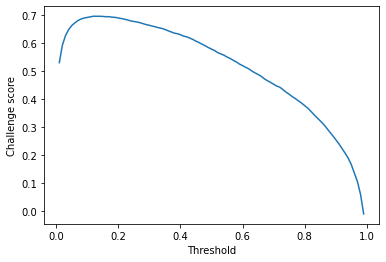

In [ ]:
#@title Challenge Metric

def compute_modified_confusion_matrix(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0/normalization

    return A

def compute_challenge_metric(weights, labels, outputs, classes, sinus_rhythm):
    num_recordings, num_classes = np.shape(labels)
    if sinus_rhythm in classes:
        sinus_rhythm_index = classes.index(sinus_rhythm)
    else:
        raise ValueError('The sinus rhythm class is not available.')

    # Compute the observed score.
    A = compute_modified_confusion_matrix(labels, outputs)
    observed_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the correct label(s).
    correct_outputs = labels
    A = compute_modified_confusion_matrix(labels, correct_outputs)
    correct_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the sinus rhythm class.
    inactive_outputs = np.zeros((num_recordings, num_classes), dtype=bool)
    inactive_outputs[:, sinus_rhythm_index] = 1
    A = compute_modified_confusion_matrix(labels, inactive_outputs)
    inactive_score = np.nansum(weights * A)

    if correct_score != inactive_score:
        normalized_score = float(observed_score - inactive_score) / float(correct_score - inactive_score)
    else:
        normalized_score = 0.0

    return normalized_score

def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

def is_finite_number(x):
    if is_number(x):
        return np.isfinite(float(x))
    else:
        return False

def load_table(table_file):
    # The table should have the following form:
    #
    # ,    a,   b,   c
    # a, 1.2, 2.3, 3.4
    # b, 4.5, 5.6, 6.7
    # c, 7.8, 8.9, 9.0
    #
    table = list()
    with open(table_file, 'r') as f:
        for i, l in enumerate(f):
            arrs = [arr.strip() for arr in l.split(',')]
            table.append(arrs)

    # Define the numbers of rows and columns and check for errors.
    num_rows = len(table)-1
    if num_rows<1:
        raise Exception('The table {} is empty.'.format(table_file))
    row_lengths = set(len(table[i])-1 for i in range(num_rows))
    if len(row_lengths)!=1:
        raise Exception('The table {} has rows with different lengths.'.format(table_file))
    num_cols = min(row_lengths)
    if num_cols<1:
        raise Exception('The table {} is empty.'.format(table_file))

    # Find the row and column labels.
    rows = [table[0][j+1] for j in range(num_rows)]
    cols = [table[i+1][0] for i in range(num_cols)]

    # Find the entries of the table.
    values = np.zeros((num_rows, num_cols), dtype=np.float64)
    for i in range(num_rows):
        for j in range(num_cols):
            value = table[i+1][j+1]
            if is_finite_number(value):
                values[i, j] = float(value)
            else:
                values[i, j] = float('nan')

    return rows, cols, values

def load_weights(weight_file):
    # Load the table with the weight matrix.
    rows, cols, values = load_table(weight_file)

    # Split the equivalent classes.
    rows = [set(row.split('|')) for row in rows]
    cols = [set(col.split('|')) for col in cols]
    assert(rows == cols)

    # Identify the classes and the weight matrix.
    classes = rows
    weights = values

    return classes, weights

weights_file = 'weights.csv'
sinus_rhythm = set(['426783006'])
classes, weights = load_weights(weights_file)
labels = np.concatenate([y for x, y in test_dataset], axis=0)
labels = labels[:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 10, 18, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25]]
outputs = model.predict(test_dataset)
outputs = outputs[:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 10, 18, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25]]
xaxis = []
yaxis = []
for i in np.arange(0.01,1,0.01):
    outputs_ = (outputs>i)*1
    m = compute_challenge_metric(weights, labels, outputs_, classes, sinus_rhythm)
    # print(i,m)
    xaxis += [i]
    yaxis += [m]
plt.xlabel('Threshold')
plt.ylabel('Challenge score')
plt.plot(xaxis, yaxis)
plt.savefig('threshold.pdf', dpi=300, bbox_inches = 'tight')

66/66 [==============================] - 3s 22ms/step - loss: 0.0745 - accuracy: 0.6489 - AUROC: 0.9344 - AUPRC: 0.5824
[0.59, 0.78, 0.29, 0.45, 0.75, 0.84, 0.65, 0.27, 0.7, 0.63, 0.37, 0.26, 0.88, 0.6, 0.82, 0.13, 0.52, 0.53, 0.4, 0.3, 0.52, 0.65, 0.96, 0.93, 0.56, 0.41]
Mean F1 Score =  0.5684586711801015


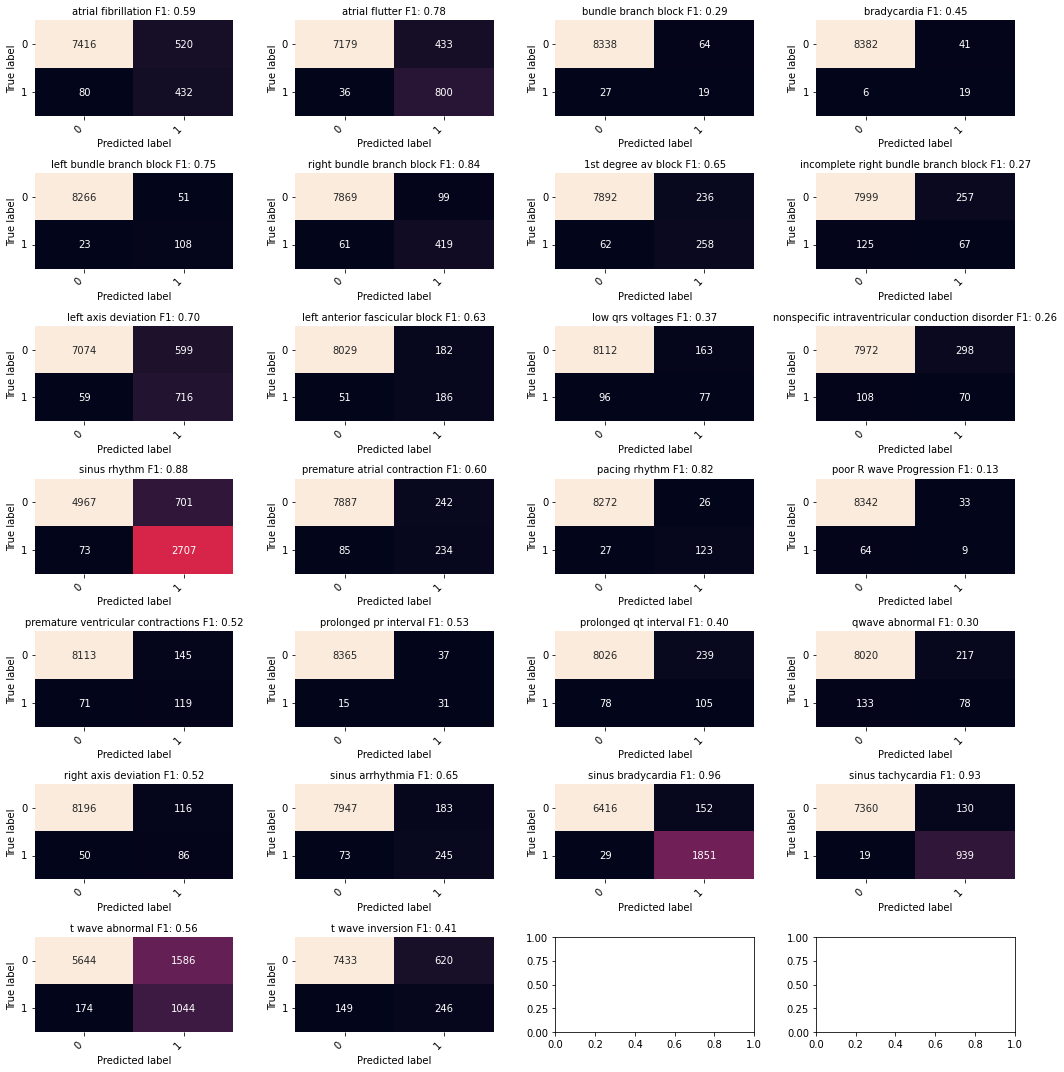

In [ ]:
#@title F1 Scores
def plot_confusion_matrix(cm, labels, results):
    def print_confusion_matrix(confusion_matrix, axes, class_label, result, class_names, fontsize=10):

        df_cm = pd.DataFrame(
            confusion_matrix, index=class_names, columns=class_names,
        )

        try:
            heatmap = sn.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        axes.set_ylabel('True label',fontsize=fontsize)
        axes.set_xlabel('Predicted label',fontsize=fontsize)
        axes.set_title(str(class_label)+' F1: {:.2f}'.format(round(result, 2)),fontsize=fontsize)

    fig, ax = plt.subplots(7, 4, figsize=(15, 15))
        
    for axes, cfs_matrix, label, result in zip(ax.flatten(), cm, labels, results):
        print_confusion_matrix(cfs_matrix, axes, label, result, ["0", "1"])

    fig.tight_layout()
    return fig

model.evaluate(test_dataset)
x = model.predict(test_dataset)
y = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = y
y_pred = x
# for i in np.arange(0.1,1,0.1):
metric = tfa.metrics.F1Score(num_classes=26, threshold=0.15)
metric.update_state(y_true, y_pred)
results = metric.result().numpy().tolist()
print([round(i,2) for i in results])
print('Mean F1 Score = ', np.mean(results))
labels = ["164889003","164890007","6374002","426627000","733534002","713427006","270492004","713426002","39732003","445118002","251146004","698252002","426783006","284470004","10370003","365413008","427172004","164947007","111975006","164917005","47665007","427393009","426177001","427084000","164934002","59931005"]
labels = ['atrial fibrillation','atrial flutter','bundle branch block','bradycardia','left bundle branch block','right bundle branch block','1st degree av block','incomplete right bundle branch block','left axis deviation','left anterior fascicular block','low qrs voltages','nonspecific intraventricular conduction disorder','sinus rhythm','premature atrial contraction','pacing rhythm','poor R wave Progression','premature ventricular contractions','prolonged pr interval','prolonged qt interval','qwave abnormal','right axis deviation','sinus arrhythmia','sinus bradycardia','sinus tachycardia','t wave abnormal','t wave inversion']
# print('F1 Score for each class = ', [i for i in result.numpy()])
x = (x>0.13)*1
cm = sklearn.metrics.multilabel_confusion_matrix(y,x)

figure = plot_confusion_matrix(cm, labels, results)

In [ ]:
# model.save_weights('gs://nima_ecg/weightsfinal/')

# From here on contains information required for research paper

https://iopscience.iop.org/article/10.1088/1361-6579/ac73d5


# Noise Addition

In [ ]:
noleads = 2
snr = -5

def noiseparse_example(serialized, image_shape=(2000, 36),label_shape=(26,)):
    features = {'image': tf.io.FixedLenFeature([], tf.string), 'label': tf.io.FixedLenFeature([], tf.string)}
    parsed_example = tf.io.parse_single_example(serialized=serialized, features=features)
    label_raw = parsed_example['label']
    image_raw = parsed_example['image']
    image = tf.io.decode_raw(image_raw, tf.float32)
    image = tf.reshape(image, shape=image_shape)
    signal = tf.experimental.numpy.take(image,indices(noleads)[0],axis=-1)
    signal = signal + tf.random.normal((2000,noleads), stddev = tf.math.sqrt((tf.math.reduce_sum((tf.experimental.numpy.take(image,[1],axis=-1))**2)/2000)/(10**(snr/10))))
    image = tf.experimental.numpy.take(image,indices(noleads)[1],axis=-1)
    label = tf.io.decode_raw(label_raw, tf.float32)
    label = tf.reshape(label, shape=label_shape)
    return {'signal':signal,'fft':image}, label

noise_dataset = tf.data.TFRecordDataset('gs://nima_ecg/early/processed_test.tfrecord')
noise_dataset = noise_dataset.map(noiseparse_example,num_parallel_calls=AUTOTUNE)
noise_dataset = noise_dataset.batch(128, drop_remainder=True)
noise_dataset = noise_dataset.prefetch(AUTOTUNE)

66/66 [==============================] - 4s 29ms/step - loss: 0.1823 - accuracy: 0.3832 - AUROC: 0.8236 - AUPRC: 0.3406
[0.43, 0.43, 0.07, 0.28, 0.56, 0.55, 0.17, 0.12, 0.34, 0.28, 0.21, 0.02, 0.52, 0.23, 0.68, 0.0, 0.39, 0.11, 0.03, 0.0, 0.04, 0.02, 0.53, 0.46, 0.15, 0.05]
Mean F1 Score =  0.2565489345445083


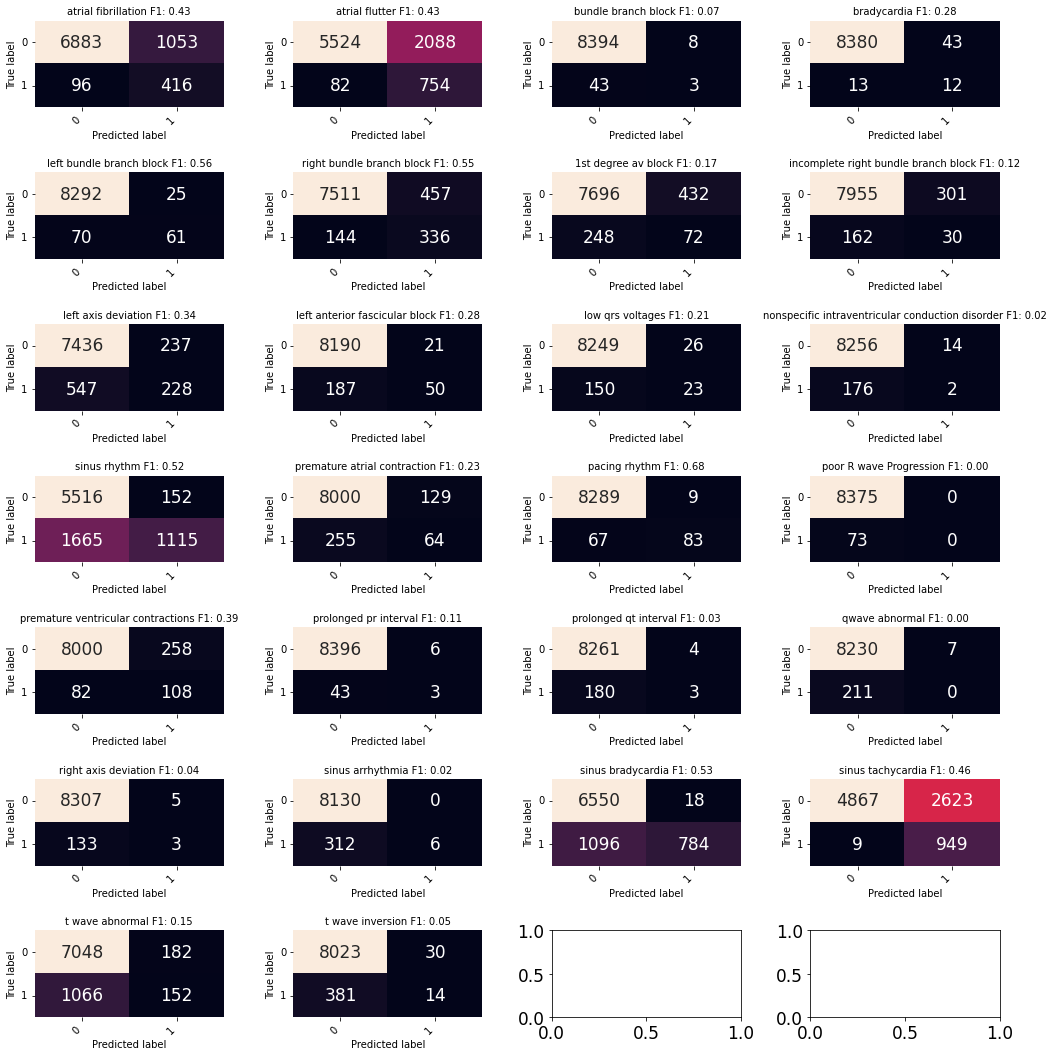

In [ ]:
#@title F1 Scores
def plot_confusion_matrix(cm, labels, results):
    def print_confusion_matrix(confusion_matrix, axes, class_label, result, class_names, fontsize=10):

        df_cm = pd.DataFrame(
            confusion_matrix, index=class_names, columns=class_names,
        )

        try:
            heatmap = sn.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        axes.set_ylabel('True label',fontsize=fontsize)
        axes.set_xlabel('Predicted label',fontsize=fontsize)
        axes.set_title(str(class_label)+' F1: {:.2f}'.format(round(result, 2)),fontsize=fontsize)

    fig, ax = plt.subplots(7, 4, figsize=(15, 15))
        
    for axes, cfs_matrix, label, result in zip(ax.flatten(), cm, labels, results):
        print_confusion_matrix(cfs_matrix, axes, label, result, ["0", "1"])

    fig.tight_layout()
    return fig

model.evaluate(noise_dataset)
x = model.predict(noise_dataset)
y = np.concatenate([y for x, y in noise_dataset], axis=0)
y_true = y
y_pred = x
# for i in np.arange(0.1,1,0.1):
metric = tfa.metrics.F1Score(num_classes=26, threshold=0.13)
metric.update_state(y_true, y_pred)
results = metric.result().numpy().tolist()
print([round(i,2) for i in results])
print('Mean F1 Score = ', np.mean(results))
labels = ["164889003","164890007","6374002","426627000","733534002","713427006","270492004","713426002","39732003","445118002","251146004","698252002","426783006","284470004","10370003","365413008","427172004","164947007","111975006","164917005","47665007","427393009","426177001","427084000","164934002","59931005"]
labels = ['atrial fibrillation','atrial flutter','bundle branch block','bradycardia','left bundle branch block','right bundle branch block','1st degree av block','incomplete right bundle branch block','left axis deviation','left anterior fascicular block','low qrs voltages','nonspecific intraventricular conduction disorder','sinus rhythm','premature atrial contraction','pacing rhythm','poor R wave Progression','premature ventricular contractions','prolonged pr interval','prolonged qt interval','qwave abnormal','right axis deviation','sinus arrhythmia','sinus bradycardia','sinus tachycardia','t wave abnormal','t wave inversion']
# print('F1 Score for each class = ', [i for i in result.numpy()])
x = (x>0.13)*1
cm = sklearn.metrics.multilabel_confusion_matrix(y,x)

figure = plot_confusion_matrix(cm, labels, results)

In [ ]:
y_pred = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
test_set = np.concatenate([x[0]['signal'][:,:,1] for x in test_dataset], axis=0)

In [ ]:
#@title SQI using NK
c=[]
for i,j in enumerate(test_set):
    if i%1000==0: print(i)
    c+=[nk.ecg.ecg_quality(j,sampling_rate=100, method='zhao2018')]
# print(c)

0
1000
2000
3000
4000
5000
6000
7000
8000


(8448, 26)
(4249,)
[0.57, 0.8, 0.0, 0.45, 0.0, 0.86, 0.63, 0.24, 0.71, 0.57, 0.41, 0.26, 0.89, 0.64, 0.77, 0.1, 0.48, 0.58, 0.42, 0.33, 0.49, 0.72, 0.96, 0.95, 0.56, 0.39]
Mean F1 Score =  0.5300991188448209
(3395,)
[0.61, 0.78, 0.34, 0.33, 0.78, 0.82, 0.65, 0.25, 0.68, 0.65, 0.35, 0.26, 0.86, 0.56, 0.87, 0.19, 0.5, 0.51, 0.37, 0.29, 0.54, 0.6, 0.96, 0.9, 0.54, 0.4]
Mean F1 Score =  0.5609857371220222
(804,)
[0.59, 0.69, 0.32, 0.73, 0.78, 0.84, 0.59, 0.38, 0.65, 0.56, 0.37, 0.23, 0.84, 0.51, 0.71, 0.2, 0.66, 0.62, 0.4, 0.31, 0.46, 0.47, 0.91, 0.89, 0.5, 0.31]
Mean F1 Score =  0.55772882184157


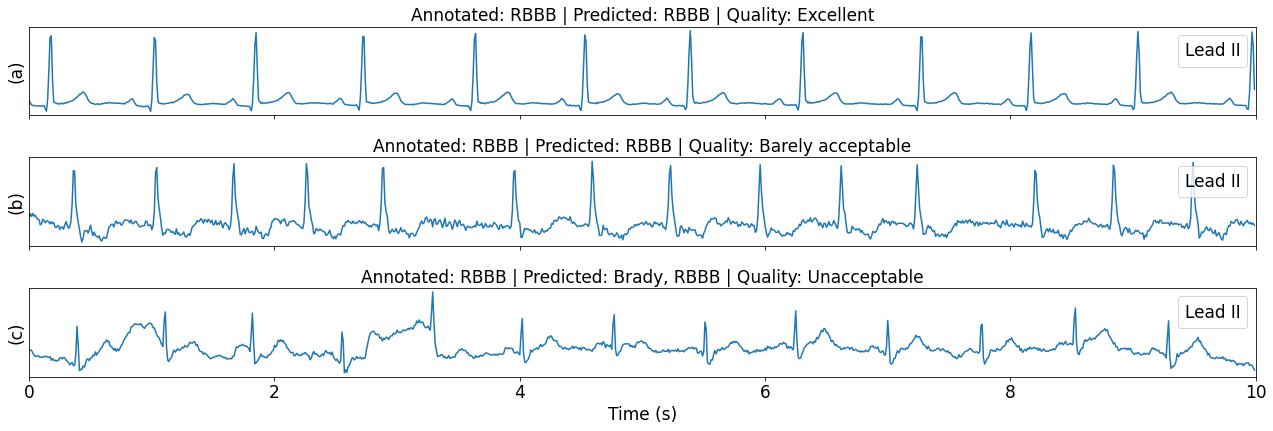

In [ ]:
abb = ['AF','AFL','BBB','Brady','LBBB','RBBB','IAVB','IRBBB','LAD','LAnFB','LQRSV','NSIVCB','NSR','PAC','PR','PRWP','PVC','LPR','LQT','QAb','RAD','SA','SB','STach','TAb','TInv']
x = np.arange(0,10,0.01)
print(y_true.shape)

d = np.where(np.array(c) == 'Excellent')
print(d[0].shape)
yt = np.take(y_true,d[0],axis=0)
yp = np.take(y_pred,d[0],axis=0)
metric = tfa.metrics.F1Score(num_classes=26, threshold=0.13)
metric.update_state(yt, yp)
results = metric.result().numpy().tolist()
print([round(i,2) for i in results])
print('Mean F1 Score = ', np.mean(results))
fig, ax = plt.subplots(3,1,figsize=(18,3*2), sharex=True)
exx = 3
ax[0].plot(x, test_set[d[0][exx]][:1000])
ax[0].set_title('Annotated: '+str(np.array(abb)[yt.astype(bool)[d[0][exx]]].tolist()).replace('\'','')[1:-1]+' | Predicted: '+str(np.array(abb)[(yp>0.13)[d[0][exx]]].tolist()).replace('\'','')[1:-1] +' | Quality: Excellent', fontsize = 17)
ax[0].set_ylabel('(a)')
ax[0].legend(['Lead II'], handlelength=0, handletextpad=0)
ax[0].set_xlim(0, 10)
ax[0].set_yticks([])

d = np.where(np.array(c) == 'Barely acceptable')
print(d[0].shape)
yt = np.take(y_true,d[0],axis=0)
yp = np.take(y_pred,d[0],axis=0)
metric = tfa.metrics.F1Score(num_classes=26, threshold=0.13)
metric.update_state(yt, yp)
results = metric.result().numpy().tolist()
print([round(i,2) for i in results])
print('Mean F1 Score = ', np.mean(results))
exx = 1
ax[1].plot(x, test_set[d[0][exx]][:1000])
ax[1].set_title('Annotated: '+str(np.array(abb)[yt.astype(bool)[d[0][exx]]].tolist()).replace('\'','')[1:-1]+' | Predicted: '+str(np.array(abb)[(yp>0.13)[d[0][exx]]].tolist()).replace('\'','')[1:-1] +' | Quality: Barely acceptable', fontsize = 17)
ax[1].set_ylabel('(b)')
ax[1].legend(['Lead II'], handlelength=0, handletextpad=0)
ax[1].set_xlim(0, 10)
ax[1].set_yticks([])

d = np.where(np.array(c) == 'Unacceptable')
print(d[0].shape)
yt = np.take(y_true,d[0],axis=0)
yp = np.take(y_pred,d[0],axis=0)
metric = tfa.metrics.F1Score(num_classes=26, threshold=0.13)
metric.update_state(yt, yp)
results = metric.result().numpy().tolist()
print([round(i,2) for i in results])
print('Mean F1 Score = ', np.mean(results))
exx = 0
ax[2].plot(x, test_set[d[0][exx]][:1000])
ax[2].set_title('Annotated: '+str(np.array(abb)[yt.astype(bool)[d[0][exx]]].tolist()).replace('\'','')[1:-1]+' | Predicted: '+str(np.array(abb)[(yp>0.13)[d[0][exx]]].tolist()).replace('\'','')[1:-1] +' | Quality: Unacceptable', fontsize = 17)
ax[2].set_ylabel('(c)')
ax[2].legend(['Lead II'], handlelength=0, handletextpad=0)
ax[2].set_xlim(0, 10)
ax[2].set_yticks([])

fig.tight_layout()
plt.xlabel('Time (s)')
plt.rcParams.update({'font.size': 17})
plt.savefig('sqi.pdf', dpi=300, bbox_inches = 'tight')

Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


41 0
[ 950 1232   83   41  158  518  490  324 1315  368  240  368 3407  476
  149   42  263   68  344  295  202  428 1998 1067 2628  865]


<BarContainer object of 26 artists>

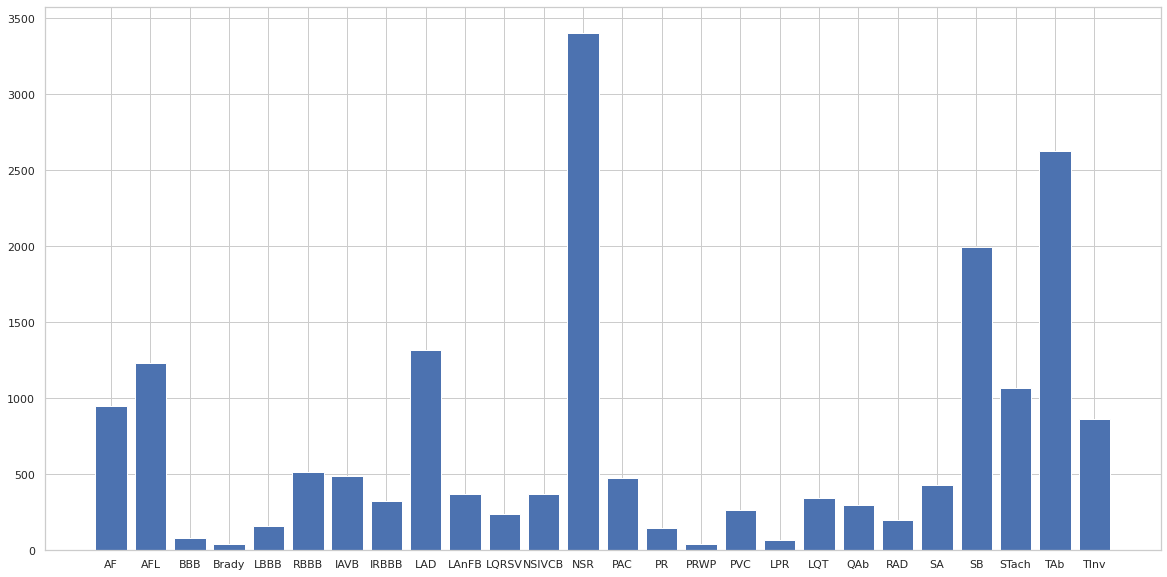

In [ ]:
y_pred = (model.predict(test_dataset)>0.13)*1
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
bbb = []
ddd = []
abb = ['AF','AFL','BBB','Brady','LBBB','RBBB','IAVB','IRBBB','LAD','LAnFB','LQRSV','NSIVCB','NSR','PAC','PR','PRWP','PVC','LPR','LQT','QAb','RAD','SA','SB','STach','TAb','TInv']

c1=0
c2=0
for i in range(len(y_pred)):
    # if ((y_true[i][2] == 1) and (y_true[i][4] == 0) and (y_true[i][5] == 0) and (y_true[i][7] == 0) and (y_true[i][9] == 0)):
    if ((y_true[i][3] == 0)):
        ddd+=[y_true[i]]
        if ((y_pred[i][3] == 1)):
            c1+=1
            if ((y_true[i][22] == 1)):
        # if ((y_pred[i][5] == 1)):
                c2+=1
        # print(y_pred[i])
        bbb+=[y_pred[i]]
print(c1, c2)
fig = plt.subplots(figsize=(20,10))
bbb = np.sum(np.array(bbb),axis = 0)
ddd = np.sum(np.array(ddd),axis = 0)
print(bbb)
plt.bar(abb,bbb)

# Violin Plot

In [ ]:
bpm = []
prediction = []
disease = []
for i in range(len(test_set)):
    if y_true[i][22] == 1:
        try:
            ecg_signal = nk.signal.signal_sanitize(test_set[i])
            ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=100, method='neurokit')
            instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned=ecg_cleaned, sampling_rate=100, method='neurokit', correct_artifacts=True)
            rate = nk.signal.signal_rate(rpeaks, sampling_rate=100, desired_length=len(ecg_cleaned))
            bpm+=[np.mean(rate)]
        except:
            continue
        if y_pred[i][22] < 0.13:
            prediction+=['FN']
        else:
            prediction+=['TP']
        disease+=['(b) SB']
    if y_true[i][23] == 1:
        try:
            ecg_signal = nk.signal.signal_sanitize(test_set[i])
            ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=100, method='neurokit')
            instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned=ecg_cleaned, sampling_rate=100, method='neurokit', correct_artifacts=True)
            rate = nk.signal.signal_rate(rpeaks, sampling_rate=100, desired_length=len(ecg_cleaned))
            bpm+=[np.mean(rate)]
        except:
            continue
        if y_pred[i][23] < 0.13:
            prediction+=['FN']
        else:
            prediction+=['TP']
        disease+=['(a) STach']

dataset = pd.DataFrame({'Arrhythmia': disease, 'Heart Rate': bpm, 'Prediction': prediction})

divide by zero encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice.
invalid value encountered in double_scalars
Too few peaks detected to compute the rate. Returning empty vector.


In [ ]:
stachcorrect = 0
stachwrong = 0
sbcorrect = 0
sbwrong = 0
for i in range(len(disease)):
    if disease[i] == '(a) STach':
        if prediction[i] == 'Correct':
            stachcorrect+=1
        if prediction[i] == 'Wrong':
            stachwrong+=1
    if disease[i] == '(b) SB':
        if prediction[i] == 'Correct':
            sbcorrect+=1
        if prediction[i] == 'Wrong':
            sbwrong+=1
print('Stach Correct: ',stachcorrect)
print('Stach Wrong: ',stachwrong)
print('SB Correct: ',sbcorrect)
print('SB Wrong: ',sbwrong)

Stach Correct:  0
Stach Wrong:  0
SB Correct:  0
SB Wrong:  0


In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
dataset

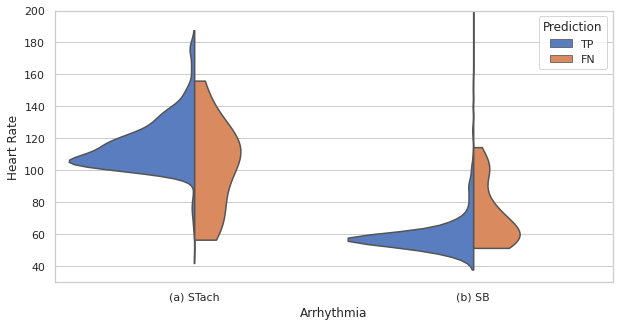

In [ ]:
sn.set(rc={'figure.figsize':[10,5]})
sn.set_style('whitegrid')
ax = sn.violinplot(x="Arrhythmia", y="Heart Rate", hue="Prediction",data=dataset, palette="muted", split=True, scale='area', scale_hue=True, dodge=True, cut=0, inner=None, width = 0.9)
plt.ylim(30,200)
plt.savefig('violin.pdf',dpi=300)

# SHAP

In [ ]:
x1=np.empty((0,2000,2))
x2=np.empty((0,2000,4))
y= np.empty((0,26))

c=0
j=0
while j<26:
    for i in train_dataset:
        for l,k in enumerate(i[1]):
            if j==26:
                break
            if k[j]==1:
                x1 = np.append(x1,[i[0]['signal'][l]],axis=0)
                x2 = np.append(x2,[i[0]['fft'][l]],axis=0)
                y = np.append(y,[i[1][l]],axis=0)
                if c<29:
                    c+=1
                else:
                    c=0
                    j+=1

print(x1.shape, x2.shape, y.shape)

(780, 2000, 2) (780, 2000, 4) (780, 26)


In [ ]:
x1test=np.empty((0,2000,2))
x2test=np.empty((0,2000,4))
ytest= np.empty((0,26))

s=0
t=1
c=0
j=0
new = -1
while j<26:
    for i in test_dataset:
        predictions = (model.predict(i[0])>0.13)*1
        for l,k in enumerate(i[1]):
            if j==26:
                break
            if (k[j]==t) and (predictions[l][j] == s):
                    x1test = np.append(x1test,[i[0]['signal'][l]],axis=0)
                    x2test = np.append(x2test,[i[0]['fft'][l]],axis=0)
                    ytest = np.append(ytest,[i[1][l]],axis=0)
                    if 0 <= c < 2:
                        c+=1
                    elif 2 <= c < 5:
                        c+=1
                        s=1
                    elif 5 <= c < 8:
                        c+=1
                        s=1
                        t=0
                    else:
                        c=0
                        s=0
                        t=1
                        j+=1

print(x1test.shape, x2test.shape, ytest.shape)

(234, 2000, 2) (234, 2000, 4) (234, 26)


In [ ]:
# with open('x1.txt','wb') as fp:
#     pickle.dump(x1,fp)
# with open('x2.txt','wb') as fp:
#     pickle.dump(x2,fp)
# with open('y.txt','wb') as fp:
#     pickle.dump(y,fp)
# with open('x1test.txt','wb') as fp:
#     pickle.dump(x1test,fp)
# with open('x2test.txt','wb') as fp:
#     pickle.dump(x2test,fp)
# with open('ytest.txt','wb') as fp:
#     pickle.dump(ytest,fp)
# with open('CCC.txt','wb') as fp:
#     pickle.dump(CCC,fp)

# !gsutil mv x* gs://nima_ecg/
# !gsutil mv y* gs://nima_ecg/
# !gsutil mv CCC.txt gs://nima_ecg/

NameError: ignored

In [ ]:
# sample = 86
# print(ytest.astype(np.bool))
labels = ['atrial fibrillation','atrial flutter','bundle branch block','bradycardia','left bundle branch block','right bundle branch block','1st degree av block','incomplete right bundle branch block','left axis deviation','left anterior fascicular block','low qrs voltages','nonspecific intraventricular conduction disorder','sinus rhythm','premature atrial contraction','pacing rhythm','poor R wave Progression','premature ventricular contractions','prolonged pr interval','prolonged qt interval','qwave abnormal','right axis deviation','sinus arrhythmia','sinus bradycardia','sinus tachycardia','t wave abnormal','t wave inversion']
for i in range(52):
    print(i, np.array(labels)[ytest.astype(np.bool)[i]])

0 ['atrial fibrillation']
1 ['atrial fibrillation']
2 ['atrial fibrillation']
3 ['atrial fibrillation']
4 ['atrial fibrillation']
5 ['atrial fibrillation']
6 ['premature atrial contraction']
7 ['left bundle branch block' '1st degree av block']
8 ['premature ventricular contractions']
9 ['atrial flutter' 'right bundle branch block']
10 ['atrial flutter' 't wave abnormal']
11 ['atrial flutter' 'prolonged qt interval' 'sinus arrhythmia']
12 ['atrial flutter' 't wave abnormal']
13 ['atrial flutter' 'prolonged qt interval' 'qwave abnormal'
 't wave abnormal']
14 ['atrial fibrillation' 'atrial flutter' 'left axis deviation']
15 ['atrial fibrillation' 'left axis deviation' 'qwave abnormal']
16 ['atrial fibrillation' 'sinus rhythm']
17 ['atrial fibrillation' 't wave abnormal']
18 ['bundle branch block' '1st degree av block'
 'left anterior fascicular block' 'sinus bradycardia' 't wave abnormal'
 't wave inversion']
19 ['bundle branch block' '1st degree av block' 'sinus bradycardia']
20 ['bundl

In [ ]:
# print(model.predict([x1test,x2test]))
# print((model.predict([x1test,x2test])>0.16)*1)
CCC = model.predict([x1test,x2test])>0.13
for i in range(52):
    print(i, np.array(labels)[CCC[i]])

0 ['premature atrial contraction']
1 ['atrial flutter' 'left axis deviation' 't wave abnormal']
2 ['premature atrial contraction' 'premature ventricular contractions']
3 ['atrial fibrillation']
4 ['atrial fibrillation']
5 ['atrial fibrillation']
6 ['atrial fibrillation' 'premature atrial contraction' 'sinus tachycardia']
7 ['atrial fibrillation' 'atrial flutter' 'left bundle branch block']
8 ['atrial fibrillation' 'atrial flutter'
 'premature ventricular contractions' 'prolonged qt interval'
 't wave abnormal' 't wave inversion']
9 ['premature atrial contraction' 'prolonged qt interval' 't wave abnormal']
10 ['nonspecific intraventricular conduction disorder' 'sinus rhythm'
 'premature atrial contraction' 't wave abnormal']
11 ['premature atrial contraction' 'premature ventricular contractions'
 'prolonged qt interval' 't wave abnormal']
12 ['atrial fibrillation' 'atrial flutter' 't wave abnormal'
 't wave inversion']
13 ['atrial flutter' 't wave abnormal']
14 ['atrial fibrillation' 'a

In [ ]:
e = shap.GradientExplainer(model, [x1,x2])

In [ ]:
svf = []
for i in range(234):
    svf += [e.shap_values([np.expand_dims(x1test[i],0),np.expand_dims(x2test[i],0)])]
    print(i)

In [ ]:
# with open('svf.txt','wb') as fp:
#     pickle.dump(svf,fp)
# !gsutil mv svf.txt gs://nima_ecg/

# Generating Graphs

In [ ]:
#@title Generate all Graphs
plt.ioff()
labels = ['atrial fibrillation','atrial flutter','bundle branch block','bradycardia',
          'left bundle branch block','right bundle branch block','1st degree av block',
          'incomplete right bundle branch block','left axis deviation','left anterior fascicular block',
          'low qrs voltages','nonspecific intraventricular conduction disorder','sinus rhythm',
          'premature atrial contraction','pacing rhythm','poor R wave Progression','premature ventricular contractions',
          'prolonged pr interval','prolonged qt interval','qwave abnormal','right axis deviation','sinus arrhythmia',
          'sinus bradycardia','sinus tachycardia','t wave abnormal','t wave inversion']
for i in range(26):
    os.mkdir('Results_'+str(labels[i]))
    for a in range(9):
        fig, axs = plt.subplots(4, 1, figsize = (30,3*4), constrained_layout=True)
        x = np.arange(2000)
        y = [x1test[9*i+a][:,0],
             x1test[9*i+a][:,1],
             x2test[9*i+a][:,0],
             x2test[9*i+a][:,2]]
        z = [svf[9*i+a][i][0][0][:,0],
             svf[9*i+a][i][0][0][:,1],
             svf[9*i+a][i][1][0][:,0],
             svf[9*i+a][i][1][0][:,2]]

        for j in range(4): 
            points = np.array([x, y[j]]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            dydx = z[j]
            sigma = 3*np.std(dydx)
            norm = plt.Normalize(0, 0.002)
            lc = LineCollection(segments, cmap='viridis', norm=norm)
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs[j].add_collection(lc)
            fig.colorbar(line, ax=axs[j])

            axs[j].set_xlim(x.min(), x.max())
            axs[j].set_ylim(y[j].min(), y[j].max())

        axs[0].set_title('Original: '+str(np.array(labels)[ytest.astype(np.bool)[9*i+a]])+'\n'+'Predicted: '+str(np.array(labels)[CCC[9*i+a]])+'\nLEAD I')
        axs[1].set_title('LEAD II')
        axs[2].set_title('FFT of LEAD I')
        axs[3].set_title('FFT of LEAD II')
        fig.suptitle(str(labels[i]),fontsize=32)
        plt.savefig('Results_'+str(labels[i])+'/'+str(a)+'.png')
        plt.close('all')

In [ ]:
!gsutil cp gs://nima_ecg/x* /content/
!gsutil cp gs://nima_ecg/y* /content/
!gsutil cp gs://nima_ecg/svf.txt /content/
!gsutil cp gs://nima_ecg/CCC.txt /content/

with open('svf.txt','rb') as fp:
    svf = pickle.load(fp)
with open('CCC.txt','rb') as fp:
    CCC = pickle.load(fp)
with open('x1.txt','rb') as fp:
    x1 = pickle.load(fp)
with open('x2.txt','rb') as fp:
    x2 = pickle.load(fp)
with open('y.txt','rb') as fp:
    y = pickle.load(fp)
with open('x1test.txt','rb') as fp:
    x1test = pickle.load(fp)
with open('x2test.txt','rb') as fp:
    x2test = pickle.load(fp)
with open('ytest.txt','rb') as fp:
    ytest = pickle.load(fp)

Copying gs://nima_ecg/x1.txt...
Copying gs://nima_ecg/x1test.txt...
Copying gs://nima_ecg/x2.txt...
Copying gs://nima_ecg/x2test.txt...
\ [4 files][ 92.8 MiB/ 92.8 MiB]                                                
Operation completed over 4 objects/92.8 MiB.                                     
Copying gs://nima_ecg/y.txt...
Copying gs://nima_ecg/ytest.txt...
/ [2 files][206.3 KiB/206.3 KiB]                                                
Operation completed over 2 objects/206.3 KiB.                                    
Copying gs://nima_ecg/svf.txt...
- [1 files][557.8 MiB/557.8 MiB]   51.0 MiB/s                                   
Operation completed over 1 objects/557.8 MiB.                                    
Copying gs://nima_ecg/CCC.txt...
/ [1 files][  6.1 KiB/  6.1 KiB]                                                
Operation completed over 1 objects/6.1 KiB.                                      


In [ ]:
labels = ['atrial fibrillation','atrial flutter','bundle branch block','bradycardia',
          'left bundle branch block','right bundle branch block','1st degree av block',
          'incomplete right bundle branch block','left axis deviation','left anterior fascicular block',
          'low qrs voltages','nonspecific intraventricular conduction disorder','sinus rhythm',
          'premature atrial contraction','pacing rhythm','poor R wave Progression','premature ventricular contractions',
          'prolonged pr interval','prolonged qt interval','qwave abnormal','right axis deviation','sinus arrhythmia',
          'sinus bradycardia','sinus tachycardia','t wave abnormal','t wave inversion']

abb = ['AF','AFL','BBB','Brady','LBBB','RBBB','IAVB','IRBBB','LAD','LAnFB','LQRSV','NSIVCB','NSR','PAC','PR','PRWP','PVC','LPR','LQT','QAb','RAD','SA','SB','STach','TAb','TInv']
leadabb = ['I','II']
for i,j in enumerate(labels):
    print(i,j)

viridisBig = cm.get_cmap('coolwarm', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.1, 0.9, 256)))
alph = string.ascii_lowercase

0 atrial fibrillation
1 atrial flutter
2 bundle branch block
3 bradycardia
4 left bundle branch block
5 right bundle branch block
6 1st degree av block
7 incomplete right bundle branch block
8 left axis deviation
9 left anterior fascicular block
10 low qrs voltages
11 nonspecific intraventricular conduction disorder
12 sinus rhythm
13 premature atrial contraction
14 pacing rhythm
15 poor R wave Progression
16 premature ventricular contractions
17 prolonged pr interval
18 prolonged qt interval
19 qwave abnormal
20 right axis deviation
21 sinus arrhythmia
22 sinus bradycardia
23 sinus tachycardia
24 t wave abnormal
25 t wave inversion


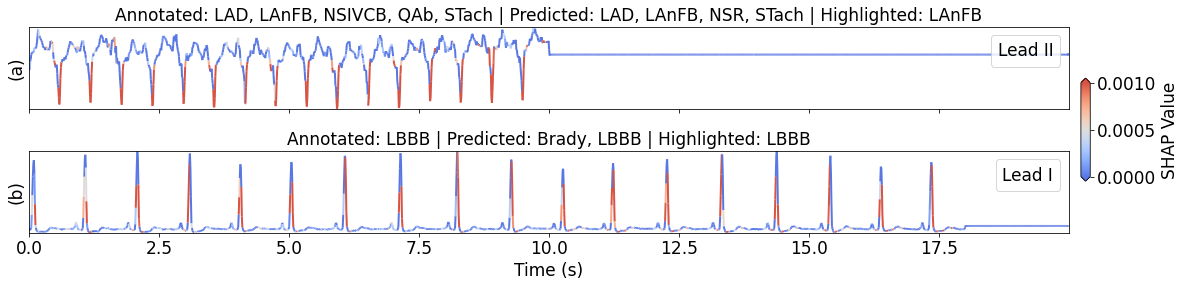

In [ ]:
#@title Zero padding
# plt.style.use('default')

dx =    [9,4]
ex =    [4,5]
lead =  [1,0]
start = [0,0]

fig, ax = plt.subplots(len(dx),1,figsize=(18,len(dx)*2), sharex=True)

for i in range(len(dx)):
    v = 9*dx[i]+ex[i]
    end = start[i]+2000
    x = np.arange(0,20,0.01)
    y = x1test[v,start[i]:end,lead[i]]
    z = svf[v][dx[i]][0][0][start[i]:end,lead[i]]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    dydx = z
    norm = plt.Normalize(0, 0.001)
    lc = LineCollection(segments, cmap=newcmp, norm=norm)
    lc.set_array(dydx)
    lc.set_linewidth(2)
    line = ax[i].add_collection(lc)
    ax[i].set_title('Annotated: '+str(np.array(abb)[ytest.astype(bool)[v]].tolist()).replace('\'','')[1:-1]+' | Predicted: '+str(np.array(abb)[CCC[v]].tolist()).replace('\'','')[1:-1] + ' | Highlighted: '+abb[dx[i]], fontsize = 17)
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_ylim(y.min(), y.max())
    ax[i].set_yticks([])
    ax[i].set_ylabel('('+alph[i]+')')
    ax[i].legend(['Lead '+leadabb[lead[i]]], handlelength=0, handletextpad=0)
    # ax[i].yaxis.set_label_position("right")
fig.tight_layout()
plt.colorbar(line, ax=ax[:],shrink=1/(len(dx)), label='SHAP Value', location='right', extend='both', pad=0.01, aspect=10)
plt.xlabel('Time (s)')
plt.rcParams.update({'font.size': 17})
plt.plot()
plt.savefig('zeropadding.pdf', dpi=300, bbox_inches = 'tight')
# plt.savefig('labelled_absent.pdf', dpi=300, bbox_inches = 'tight')

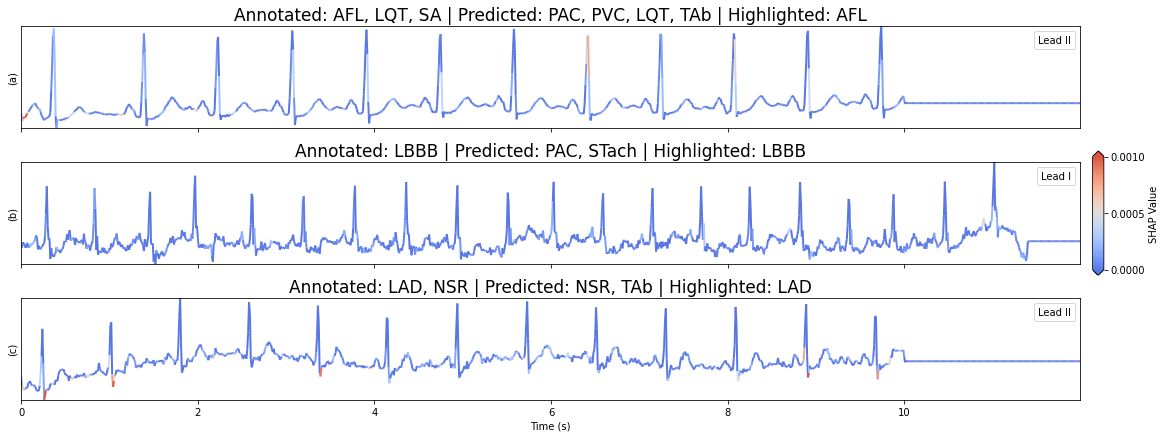

In [ ]:
#@title False Negatives
# plt.style.use('default')

dx =    [1,4,8]
ex =    [2,2,2]
lead =  [1,0,1]
start = [0,0,0]

fig, ax = plt.subplots(len(dx),1,figsize=(18,len(dx)*2), sharex=True)

for i in range(len(dx)):
    v = 9*dx[i]+ex[i]
    end = start[i]+1200
    x = np.arange(0,12,0.01)
    y = x1test[v,start[i]:end,lead[i]]
    z = svf[v][dx[i]][0][0][start[i]:end,lead[i]]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    dydx = z
    norm = plt.Normalize(0, 0.001)
    lc = LineCollection(segments, cmap=newcmp, norm=norm)
    lc.set_array(dydx)
    lc.set_linewidth(2)
    line = ax[i].add_collection(lc)
    ax[i].set_title('Annotated: '+str(np.array(abb)[ytest.astype(bool)[v]].tolist()).replace('\'','')[1:-1]+' | Predicted: '+str(np.array(abb)[CCC[v]].tolist()).replace('\'','')[1:-1] + ' | Highlighted: '+abb[dx[i]], fontsize = 17)
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_ylim(y.min(), y.max())
    ax[i].set_yticks([])
    ax[i].set_ylabel('('+alph[i]+')')
    ax[i].legend(['Lead '+leadabb[lead[i]]], handlelength=0, handletextpad=0)
fig.tight_layout()
plt.colorbar(line, ax=ax[:],shrink=1/(len(dx)), label='SHAP Value', location='right', extend='both', pad=0.01, aspect=10)
plt.xlabel('Time (s)')
plt.rcParams.update({'font.size': 17})
plt.plot()
plt.savefig('falsenegatives.pdf', dpi=300, bbox_inches = 'tight')

In [ ]:
#@title False Positives
# plt.style.use('default')

dx =    [1,4,8]
ex =    [7,7,8]
lead =  [1,0,1]
start = [0,0,0]

fig, ax = plt.subplots(len(dx),1,figsize=(18,len(dx)*2), sharex=True)

for i in range(len(dx)):
    v = 9*dx[i]+ex[i]
    end = start[i]+1000
    x = np.arange(0,10,0.01)
    y = x1test[v,start[i]:end,lead[i]]
    z = svf[v][dx[i]][0][0][start[i]:end,lead[i]]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    dydx = z
    norm = plt.Normalize(0, 0.001)
    lc = LineCollection(segments, cmap=newcmp, norm=norm)
    lc.set_array(dydx)
    lc.set_linewidth(2)
    line = ax[i].add_collection(lc)
    ax[i].set_title('Annotated: '+str(np.array(abb)[ytest.astype(bool)[v]].tolist()).replace('\'','')[1:-1]+' | Predicted: '+str(np.array(abb)[CCC[v]].tolist()).replace('\'','')[1:-1] + ' | Highlighted: '+abb[dx[i]], fontsize = 17)
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_ylim(y.min(), y.max())
    ax[i].set_yticks([])
    ax[i].set_ylabel('('+alph[i]+')')
    ax[i].legend(['Lead '+leadabb[lead[i]]], handlelength=0, handletextpad=0)
fig.tight_layout()
plt.colorbar(line, ax=ax[:],shrink=1/(len(dx)), label='SHAP Value', location='right', extend='both', pad=0.01, aspect=10)
plt.xlabel('Time (s)')
plt.rcParams.update({'font.size': 17})
plt.plot()
plt.savefig('falsepositives.pdf', dpi=300, bbox_inches = 'tight')

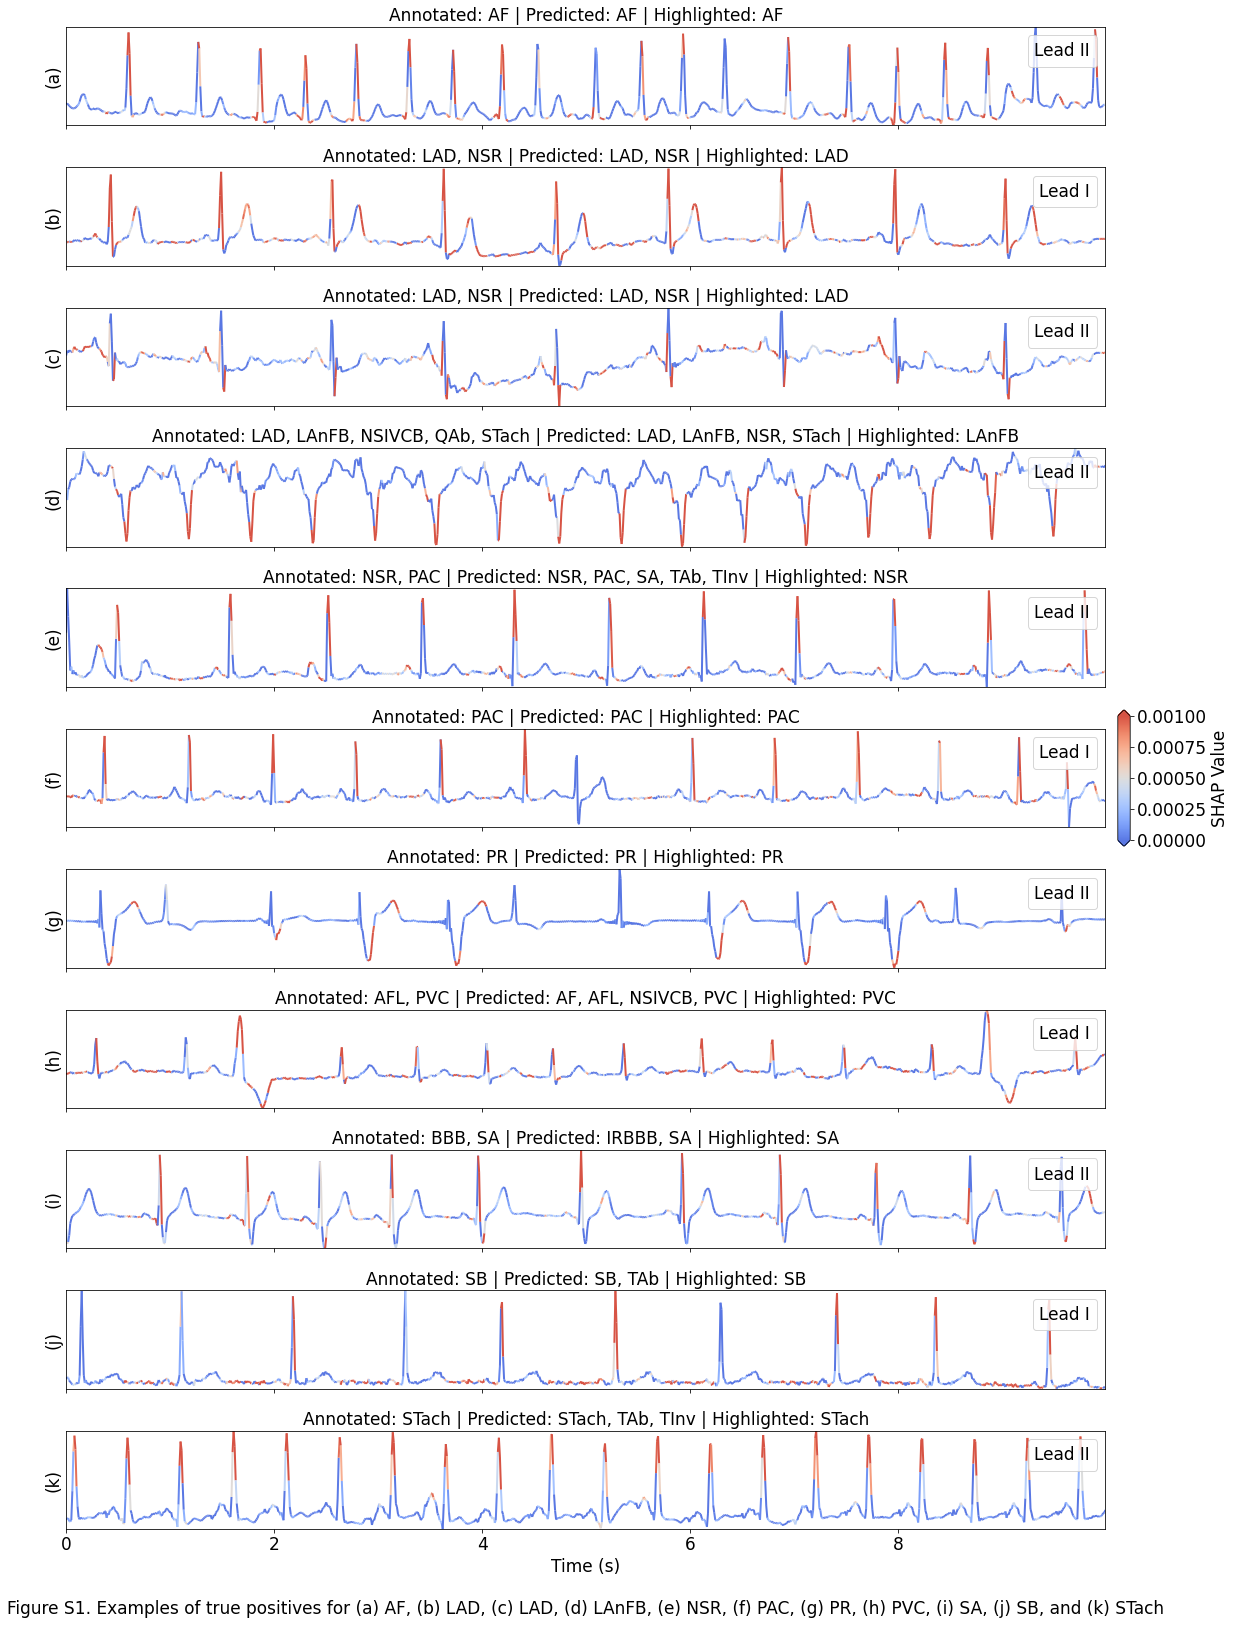

In [ ]:
#@title Supplementary
dx =    [0,8,8,9,12,13,14,16,21,22,23]
ex =    [5,3,3,4,5 ,4 ,4 ,4 ,5 ,5 ,4]
lead =  [1,0,1,1,1 ,0 ,1 ,0 ,1 ,0 ,1]
start = [999,0,0,0,0,0,0 ,0 ,0 ,0 ,0]


fig, ax = plt.subplots(len(dx),1,figsize=(18,len(dx)*2), sharex=True)

for i in range(len(dx)):
    v = 9*dx[i]+ex[i]
    end = start[i]+1000
    x = np.arange(0,10,0.01)
    y = x1test[v,start[i]:end,lead[i]]
    z = svf[v][dx[i]][0][0][start[i]:end,lead[i]]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    dydx = z
    norm = plt.Normalize(0, 0.001)
    lc = LineCollection(segments, cmap=newcmp, norm=norm)
    lc.set_array(dydx)
    lc.set_linewidth(2)
    line = ax[i].add_collection(lc)
    ax[i].set_title('Annotated: '+str(np.array(abb)[ytest.astype(bool)[v]].tolist()).replace('\'','')[1:-1]+' | Predicted: '+str(np.array(abb)[CCC[v]].tolist()).replace('\'','')[1:-1] + ' | Highlighted: '+abb[dx[i]], fontsize = 17)
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_ylim(y.min(), y.max())
    ax[i].set_yticks([])
    ax[i].set_ylabel('('+alph[i]+')')
    ax[i].legend(['Lead '+leadabb[lead[i]]], handlelength=0, handletextpad=0)
# fig.text(0, -0.05, 'test', ha='center')
fig.tight_layout()
plt.colorbar(line, ax=ax[:],shrink=1/(len(dx)), label='SHAP Value', location='right', extend='both', pad=0.01, aspect=10)
plt.xlabel('''Time (s)

Figure S1. Examples of true positives for (a) AF, (b) LAD, (c) LAD, (d) LAnFB, (e) NSR, (f) PAC, (g) PR, (h) PVC, (i) SA, (j) SB, and (k) STach''')
plt.rcParams.update({'font.size': 17})
plt.plot()
plt.savefig('supplementary.pdf', dpi=300, bbox_inches = 'tight')

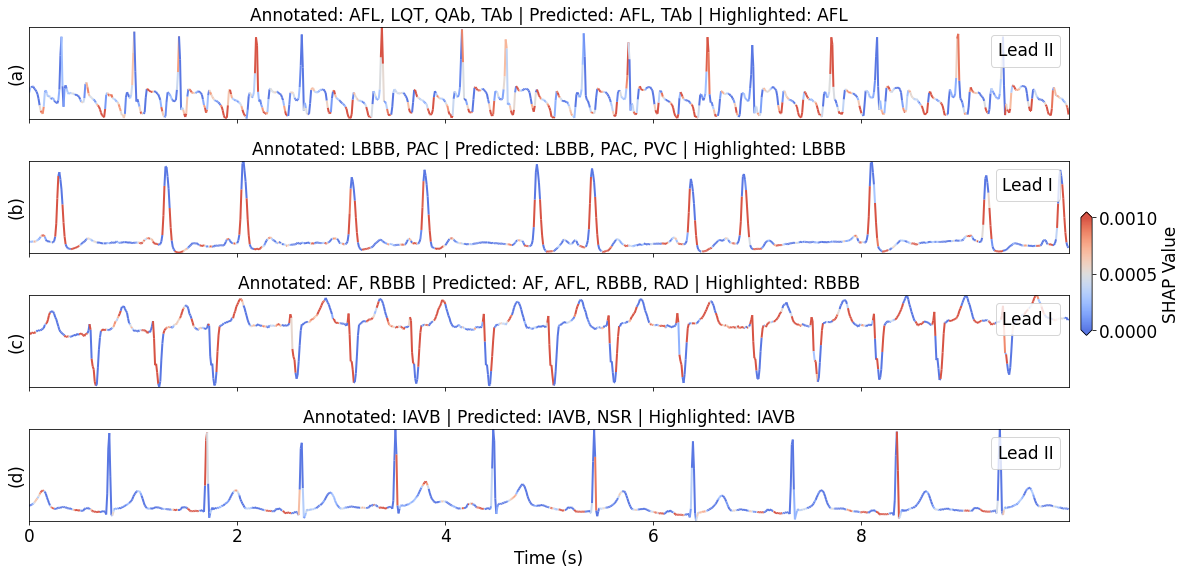

In [ ]:
#@title True Positives
dx = [1,4,5,6]
ex = [4,3,3,5]
lead = [1,0,0,1]
start = [0,0,0,0]


fig, ax = plt.subplots(len(dx),1,figsize=(18,len(dx)*2), sharex=True)

for i in range(len(dx)):
    v = 9*dx[i]+ex[i]
    end = start[i]+1000
    x = np.arange(0,10,0.01)
    y = x1test[v,start[i]:end,lead[i]]
    z = svf[v][dx[i]][0][0][start[i]:end,lead[i]]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    dydx = z
    norm = plt.Normalize(0, 0.001)
    lc = LineCollection(segments, cmap=newcmp, norm=norm)
    lc.set_array(dydx)
    lc.set_linewidth(2)
    line = ax[i].add_collection(lc)
    ax[i].set_title('Annotated: '+str(np.array(abb)[ytest.astype(bool)[v]].tolist()).replace('\'','')[1:-1]+' | Predicted: '+str(np.array(abb)[CCC[v]].tolist()).replace('\'','')[1:-1] + ' | Highlighted: '+abb[dx[i]], fontsize = 17)
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_ylim(y.min(), y.max())
    ax[i].set_yticks([])
    ax[i].set_ylabel('('+alph[i]+')')
    ax[i].legend(['Lead '+leadabb[lead[i]]], handlelength=0, handletextpad=0)
fig.tight_layout()
plt.colorbar(line, ax=ax[:],shrink=1/(len(dx)), label='SHAP Value', location='right', extend='both', pad=0.01, aspect=10)
plt.xlabel('Time (s)')
plt.rcParams.update({'font.size': 17})
plt.plot()
plt.savefig('truepositives.pdf', dpi=300, bbox_inches = 'tight')